# Segmentation client basée sur des données transactionnelles (SQL)

**Objectif :**  
Analyser les comportements clients à partir des transactions e-commerce pour produire des KPI clients, préparer une segmentation et formuler des recommandations business.

**Questions métier :**
- Combien de transactions réalise chaque client ?
- Quel est le chiffre d’affaires total et le panier moyen par client ?
- Qui sont les clients à forte valeur ou très actifs ?
- Quels segments clients peuvent être identifiés pour des actions marketing ou fidélisation ?

**Compétences démontrées :**  
- SQL pur pour extraction et agrégation  
- Création de tables analytiques  
- Calcul de KPI business  
- Visualisation avec Python  

**Dataset :** online_retail.csv (le même que Projet 1)

## Outils utilisés
- Python (pour manipulation CSV et visualisation)
- Pandas
- SQLite / SQL
- Jupyter Notebook
- Matplotlib

## Préparation

- Charger le dataset CSV.
- Calculer le chiffre d’affaires par transaction (Revenue = Quantity * UnitPrice).
- Créer une base SQLite et y importer la table transactions.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connexion SQLite
conn = sqlite3.connect("portfolio2_segmentation.db")
cursor = conn.cursor()

# Charger le CSV
df = pd.read_csv("data/online_retail.csv")

# Créer la colonne Revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Exporter vers SQLite
df.to_sql(name="transactions", con=conn, if_exists="replace", index=False)
print("Table transactions créée :", df.shape)

Table transactions créée : (541909, 9)


## Inspection SQL

- Vérifier les colonnes, le nombre total de lignes et les valeurs manquantes.
- Identifier le nombre de clients uniques.
- Cette étape permet de préparer la segmentation.

In [2]:
# Structure de la table
cursor.execute("PRAGMA table_info(transactions);")
cursor.fetchall()

[(0, 'InvoiceNo', 'TEXT', 0, None, 0),
 (1, 'StockCode', 'TEXT', 0, None, 0),
 (2, 'Description', 'TEXT', 0, None, 0),
 (3, 'Quantity', 'INTEGER', 0, None, 0),
 (4, 'InvoiceDate', 'TEXT', 0, None, 0),
 (5, 'UnitPrice', 'REAL', 0, None, 0),
 (6, 'CustomerID', 'REAL', 0, None, 0),
 (7, 'Country', 'TEXT', 0, None, 0),
 (8, 'Revenue', 'REAL', 0, None, 0)]

In [3]:
# Volume total
cursor.execute("SELECT COUNT(*) FROM transactions;")
cursor.fetchone()

(541909,)

In [4]:
# Nombre de clients uniques
cursor.execute("SELECT COUNT(DISTINCT CustomerID) FROM transactions WHERE CustomerID IS NOT NULL;")
cursor.fetchone()

(4372,)

## Table clients agrégée

**Objectif métier :**
- 1 ligne = 1 client
- Colonnes = KPIs essentiels pour segmenter et analyser les clients
- Préparer la base pour des analyses marketing et de fidélisation

**KPI calculés :**
- nb_transactions : nombre de transactions uniques
- total_revenue : chiffre d’affaires total
- avg_basket : panier moyen
- first_purchase / last_purchase : ancienneté et récence

In [15]:
# Créer la table clients
cursor.execute("DROP TABLE IF EXISTS customers;")

cursor.execute("""
CREATE TABLE customers AS
SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS nb_transactions,
    SUM(Revenue) AS total_revenue,
    AVG(Revenue) AS avg_basket,
    MIN(InvoiceDate) AS first_purchase,
    MAX(InvoiceDate) AS last_purchase
FROM transactions
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID;
""")

conn.commit()
print("Table customers créée avec succès")

Table customers créée avec succès


## Vérification

- S’assurer que chaque client est représenté par une ligne unique.
- Vérifier les KPI calculés.

In [16]:
# 5 premiers clients
cursor.execute("SELECT * FROM customers LIMIT 5;")
cursor.fetchall()

[(12346.0, 2, 0.0, 0.0, '2011-01-18 10:01:00', '2011-01-18 10:17:00'),
 (12347.0,
  7,
  4310.0,
  23.681318681318682,
  '2010-12-07 14:57:00',
  '2011-12-07 15:52:00'),
 (12348.0,
  4,
  1797.24,
  57.97548387096774,
  '2010-12-16 19:09:00',
  '2011-09-25 13:13:00'),
 (12349.0,
  1,
  1757.55,
  24.076027397260273,
  '2011-11-21 09:51:00',
  '2011-11-21 09:51:00'),
 (12350.0,
  1,
  334.4,
  19.670588235294115,
  '2011-02-02 16:01:00',
  '2011-02-02 16:01:00')]

## Visualisation des KPI clients

**Objectif :**
- Comprendre la répartition des clients
- Identifier les clients à forte valeur ou très actifs
- Détecter les clients occasionnels

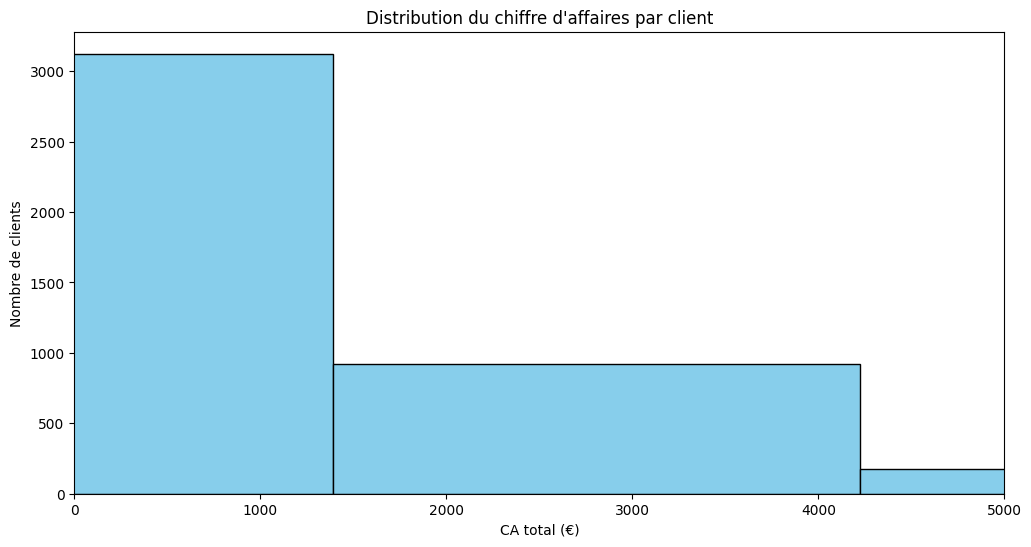

In [17]:
# Charger en pandas pour visualisation
df_customers = pd.read_sql("SELECT * FROM customers;", conn)

# Distribution du CA total par client
plt.figure(figsize=(12,6))
plt.hist(df_customers['total_revenue'], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution du chiffre d'affaires par client")
plt.xlabel("CA total (€)")
plt.ylabel("Nombre de clients")
plt.xlim(0, 5000)
plt.show()

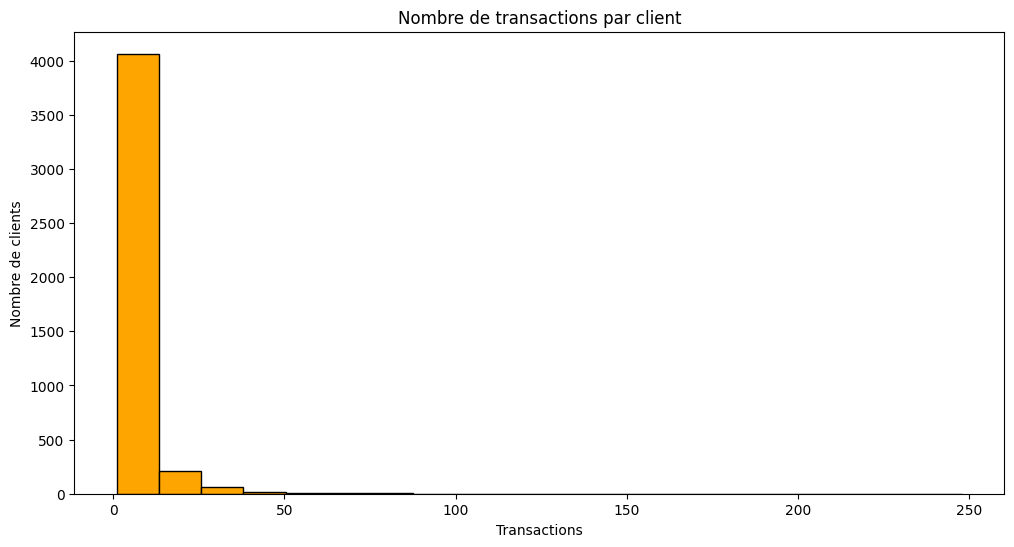

In [18]:
# Charger en pandas pour visualisation
df_customers = pd.read_sql("SELECT * FROM customers;", conn)

# Distribution du nombre de transactions par client
plt.figure(figsize=(12,6))
plt.hist(df_customers['nb_transactions'], bins=20, color='orange', edgecolor='black')
plt.title("Nombre de transactions par client")
plt.xlabel("Transactions")
plt.ylabel("Nombre de clients")
plt.show()

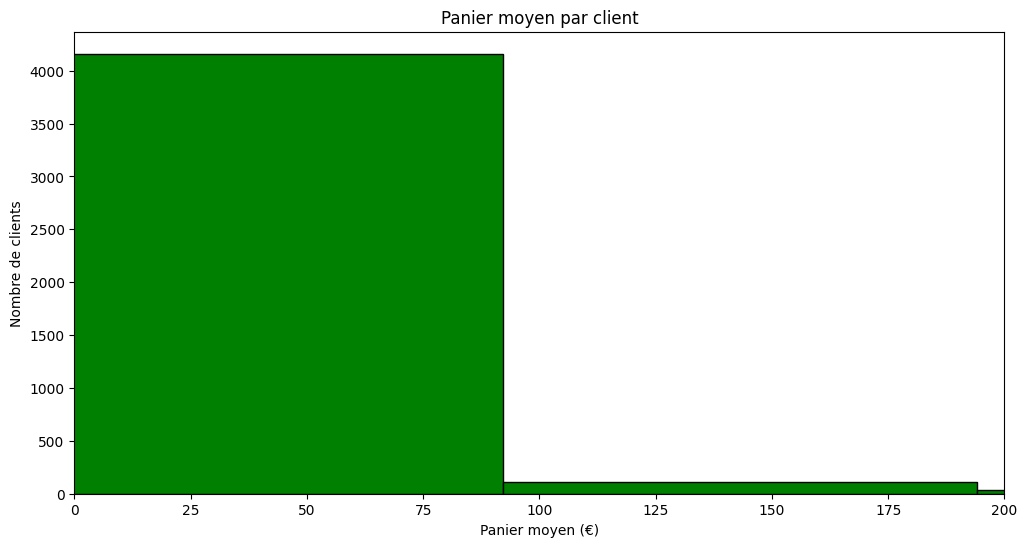

In [19]:
# Charger en pandas pour visualisation
df_customers = pd.read_sql("SELECT * FROM customers;", conn)

# Distribution du panier moyen par client
plt.figure(figsize=(12,6))
plt.hist(df_customers['avg_basket'], bins=80, color='green', edgecolor='black')
plt.title("Panier moyen par client")
plt.xlabel("Panier moyen (€)")
plt.ylabel("Nombre de clients")
plt.xlim(0, 200)
plt.show()

## Interprétation et recommandations

- La majorité des clients réalise peu de transactions et génère un CA faible.
- Quelques clients génèrent un CA très élevé (loi de Pareto) → priorité marketing et fidélisation.
- Le panier moyen montre que la plupart des clients ont des achats modestes, mais certains clients clés contribuent significativement au CA.
- Cette table est prête pour segmenter les clients (Top clients, réguliers, occasionnels) et guider des décisions business.

# Conclusion

- Une table client a été construite en SQL à partir des transactions e-commerce.
- KPI par client calculés : nombre de transactions, CA total, panier moyen, première et dernière commande.
- Visualisations montrent la répartition des clients et mettent en évidence les clients à forte valeur.
- Base prête pour segmentation et recommandations marketing.